In [1]:
# from google.colab import drive 
# drive.mount('/content/gdrive')

In [2]:
# %cd "/content/gdrive/MyDrive/Datasets"

# DeepFake Image detection

## Importing Required libraries

In [ ]:
# !pip install -U --upgrade tensorflow

In [ ]:
# %pip install sklearn
# %pip install scikit-learn
# %pip install opencv-python

In [5]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

In [6]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
tf.__version__
# with tf.device('/GPU:0'):

'2.11.0'

In [8]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Data Visualisation

In [9]:
import os

def get_data():
    return pd.read_csv('./DFDC/DFDC_metadata.csv')

In [10]:
meta=get_data()
meta.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [11]:
meta.shape

(95634, 5)

In [12]:
len(meta[meta.label=='FAKE']),len(meta[meta.label=='REAL'])

(79341, 16293)

In [13]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 8000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [14]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

In [15]:
Train_set.shape,Val_set.shape,Test_set.shape

((8960, 5), (3840, 5), (3200, 5))

In [17]:
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)

The original image dataset were biased with more fake images than real since we are taking a sample of it its better to take equal proportion of real and fake images.

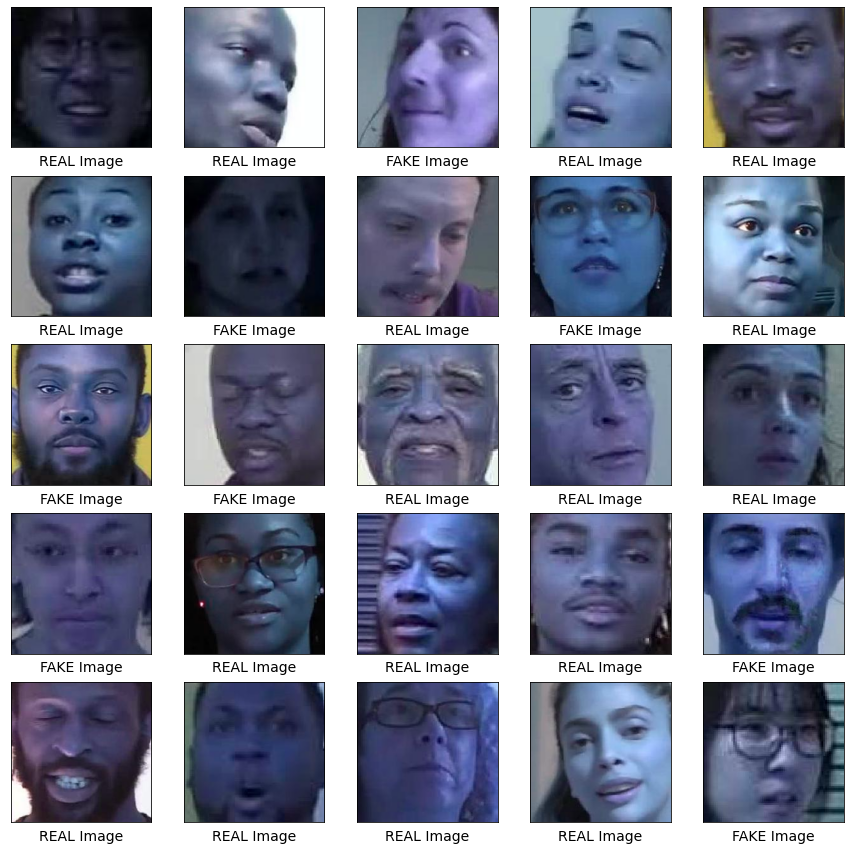

In [18]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    temp = cv2.imread('./DFDC/DFDC_Images/'+Train_set.loc[i,'videoname'][:-4]+'.jpg')
#     print(temp)
    
    plt.imshow(temp)
    
    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

## Modelling

### CNN Architecture

In [19]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        temp = cv2.imread('./DFDC/DFDC_Images/'+img[:-4]+'.jpg')
        images.append(temp)
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images),np.array(labels)

In [20]:
%%time
with tf.device('/GPU:0'):
    X_train,y_train=retreive_dataset(Train_set)
    X_val,y_val=retreive_dataset(Val_set)
    X_test,y_test=retreive_dataset(Test_set)

2022-12-16 10:27:53.686044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 10:27:54.143524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8131 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:07:00.0, compute capability: 8.0


CPU times: user 7.79 s, sys: 6.9 s, total: 14.7 s
Wall time: 36.6 s


In [21]:
from functools import partial

tf.random.set_seed(42) 
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [22]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 401408)            0

In [23]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [24]:
print(len(X_train[0]))

224


In [25]:
%%time
with tf.device('/GPU:0'):
#     opts = tf.GPUOptions(per_process_gpu_memory_fraction=1)
#     conf = tf.ConfigProto(gpu_options=opts)
#     tfe.enable_eager_execution(config=conf)
    history = model.fit(X_train, y_train, epochs=10,batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10


2022-12-16 10:29:00.874440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2022-12-16 10:29:02.993570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-16 10:29:04.200910: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-16 10:29:04.200983: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-16 10:29:05.266319: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7

140/140 [==============================] - 30s 155ms/step - loss: 101.0961 - accuracy: 0.4981 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/10
140/140 [==============================] - 21s 152ms/step - loss: 0.7065 - accuracy: 0.5002 - val_loss: 0.6935 - val_accuracy: 0.4992
Epoch 3/10
140/140 [==============================] - 21s 149ms/step - loss: 0.6932 - accuracy: 0.5030 - val_loss: 0.6935 - val_accuracy: 0.4992
Epoch 4/10
140/140 [==============================] - 21s 149ms/step - loss: 0.6932 - accuracy: 0.5049 - val_loss: 0.6936 - val_accuracy: 0.4992
Epoch 5/10
140/140 [==============================] - 21s 149ms/step - loss: 0.6933 - accuracy: 0.4931 - val_loss: 0.6933 - val_accuracy: 0.5003
Epoch 6/10
140/140 [==============================] - 21s 149ms/step - loss: 0.6935 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
140/140 [==============================] - 21s 148ms/step - loss: 0.6932 - accuracy: 0.4908 - val_loss: 0.6935 - val_accuracy: 0

In [26]:
%%time
with tf.device('/GPU:0'):
    score = model.evaluate(X_test, y_test)

100/100 [==============================] - 3s 20ms/step - loss: 0.6932 - accuracy: 0.5000
CPU times: user 1.81 s, sys: 875 ms, total: 2.69 s
Wall time: 3.39 s


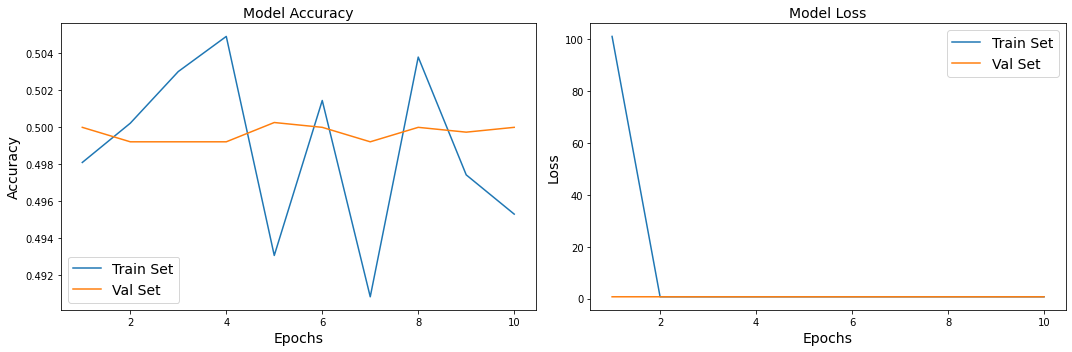

CPU times: user 199 ms, sys: 251 ms, total: 450 ms
Wall time: 171 ms


In [27]:
%%time
with tf.device('/GPU:0'):
# plot model performance
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(history.epoch) + 1)

    plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Set')
    plt.plot(epochs_range, val_acc, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Set')
    plt.plot(epochs_range, val_loss, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()

A baseline score of 50.00%

# Pretrained Models for Transfer Learning

Xception model for fine-tuning

In [28]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [29]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


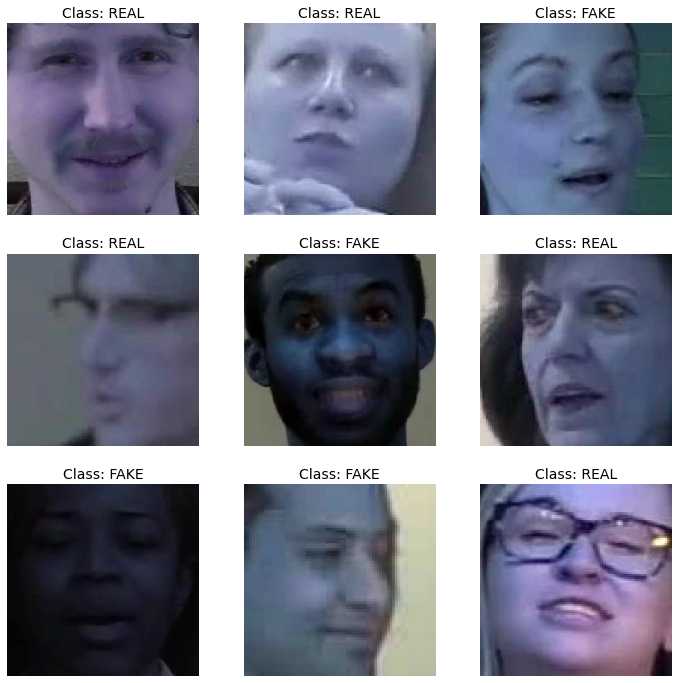

In [30]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [31]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

random data augmentations:

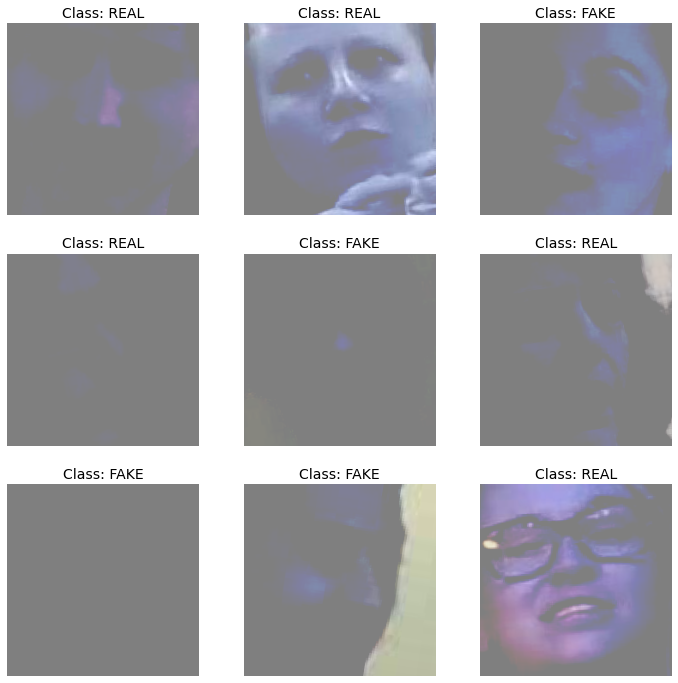

In [32]:
# extra code – displays the same first 9 images, after augmentation

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

## InceptionResNetV2

In [54]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [55]:
for layer in base_model.layers:
    layer.trainable = False

training

In [56]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
280/280 [==============================] - 44s 130ms/step - loss: 5.5104 - accuracy: 0.5479 - val_loss: 3.7105 - val_accuracy: 0.6049
Epoch 2/3
280/280 [==============================] - 34s 122ms/step - loss: 4.0151 - accuracy: 0.5847 - val_loss: 14.1389 - val_accuracy: 0.5003
Epoch 3/3
280/280 [==============================] - 34s 121ms/step - loss: 4.3571 - accuracy: 0.5978 - val_loss: 7.2368 - val_accuracy: 0.5346


In [57]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_6                33: batch_normalization_823 66: conv2d_835             99: batch_normalization_845
  1: conv2d_816             34: batch_normalization_826 67: conv2d_838            100: activation_836        
  2: batch_normalization_816 35: batch_normalization_827 68: batch_normalization_835101: activation_838        
  3: activation_812         36: activation_817         69: batch_normalization_838102: activation_841        
  4: conv2d_817             37: activation_819         70: activation_831        103: block35_3_mixed       
  5: batch_normalization_817 38: activation_822         71: activation_834        104: block35_3_conv        
  6: activation_813         39: activation_823         72: conv2d_834            105: block35_3             
  7: conv2d_818             40: mixed_5b               73: conv2d_836            106: block35_3_ac          
  8: batch_normalization_818 41: conv2d_831             74: conv2d_839            107: conv2d_849            
  9: activ

In [58]:
model.evaluate(test_set)

100/100 [==============================] - 8s 83ms/step - loss: 6.9465 - accuracy: 0.5447


[6.9465203285217285, 0.5446875095367432]

In [59]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
with tf.device('/GPU:0'):
    history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
280/280 [==============================] - 101s 265ms/step - loss: 0.9776 - accuracy: 0.6058 - val_loss: 11.8191 - val_accuracy: 0.5331
Epoch 2/10
280/280 [==============================] - 72s 258ms/step - loss: 0.5590 - accuracy: 0.7248 - val_loss: 0.9765 - val_accuracy: 0.5615
Epoch 3/10
280/280 [==============================] - 72s 258ms/step - loss: 0.4728 - accuracy: 0.7773 - val_loss: 0.5816 - val_accuracy: 0.7107
Epoch 4/10
280/280 [==============================] - 72s 258ms/step - loss: 0.3812 - accuracy: 0.8258 - val_loss: 0.5229 - val_accuracy: 0.7685
Epoch 5/10
280/280 [==============================] - 72s 258ms/step - loss: 0.2937 - accuracy: 0.8741 - val_loss: 1.8449 - val_accuracy: 0.5852
Epoch 6/10
280/280 [==============================] - 72s 257ms/step - loss: 0.1992 - accuracy: 0.9169 - val_loss: 1.1693 - val_accuracy: 0.7102
Epoch 7/10
280/280 [==============================] - 72s 258ms/step - loss: 0.1459 - accuracy: 0.9416 - val_loss: 0.7196 - val_

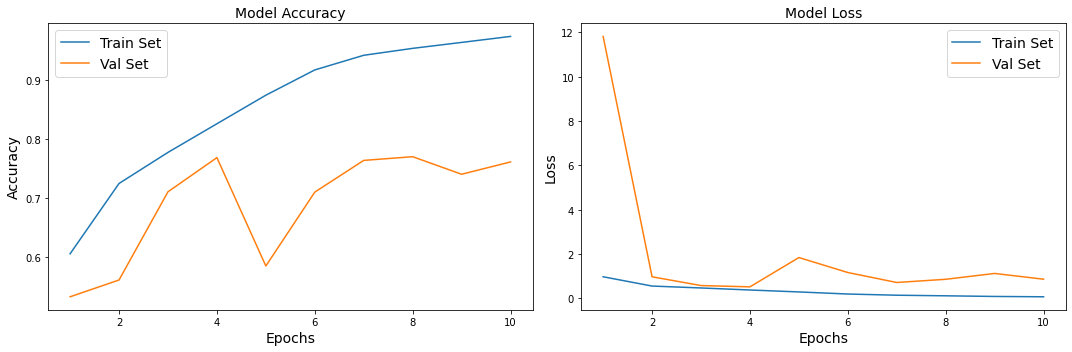

In [60]:
# plot model performance
with tf.device('/GPU:0'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(history.epoch) + 1)

    plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Set')
    plt.plot(epochs_range, val_acc, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Set')
    plt.plot(epochs_range, val_loss, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()

In [61]:
with tf.device('/GPU:0'):
    model.evaluate(test_set)

100/100 [==============================] - 8s 83ms/step - loss: 0.7984 - accuracy: 0.7628


The model accuracy finally reaches to 76.2%

## Dense Net

In [69]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.densenet.DenseNet169(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

51877672/51877672 [==============================] - 5s 0us/step


In [70]:
for layer in base_model.layers:
    layer.trainable = False

In [71]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
280/280 [==============================] - 36s 101ms/step - loss: 6.5991 - accuracy: 0.5761 - val_loss: 3.3567 - val_accuracy: 0.5870
Epoch 2/3
280/280 [==============================] - 25s 89ms/step - loss: 4.1703 - accuracy: 0.6094 - val_loss: 7.7296 - val_accuracy: 0.5258
Epoch 3/3
280/280 [==============================] - 25s 90ms/step - loss: 4.8784 - accuracy: 0.6078 - val_loss: 2.1451 - val_accuracy: 0.6557


In [72]:
model.evaluate(test_set)

100/100 [==============================] - 6s 60ms/step - loss: 2.0548 - accuracy: 0.6644


[2.0548198223114014, 0.6643750071525574]

In [73]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
280/280 [==============================] - 83s 201ms/step - loss: 1.3428 - accuracy: 0.5588 - val_loss: 3.3591 - val_accuracy: 0.5268
Epoch 2/10
280/280 [==============================] - 54s 194ms/step - loss: 0.8095 - accuracy: 0.5922 - val_loss: 0.7922 - val_accuracy: 0.5922
Epoch 3/10
280/280 [==============================] - 55s 197ms/step - loss: 0.7796 - accuracy: 0.6272 - val_loss: 0.6667 - val_accuracy: 0.6643
Epoch 4/10
280/280 [==============================] - 54s 194ms/step - loss: 0.7192 - accuracy: 0.6561 - val_loss: 3.4771 - val_accuracy: 0.5997
Epoch 5/10
280/280 [==============================] - 54s 194ms/step - loss: 0.9375 - accuracy: 0.6181 - val_loss: 7.6742 - val_accuracy: 0.4279
Epoch 6/10
280/280 [==============================] - 54s 194ms/step - loss: 0.6897 - accuracy: 0.6519 - val_loss: 0.6650 - val_accuracy: 0.6823
Epoch 7/10
280/280 [==============================] - 54s 194ms/step - loss: 0.6719 - accuracy: 0.6823 - val_loss: 0.7779 - val_ac

In [74]:
model.evaluate(test_set)

100/100 [==============================] - 6s 59ms/step - loss: 0.7865 - accuracy: 0.6403


[0.78645920753479, 0.6403124928474426]